In [1]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle
import scipy as sp
from sklearn.metrics import plot_confusion_matrix

In [3]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

def index(data, label):
    mini = data.reset_index()[data.reset_index()['labels'] == label].index.min()
    maxi = data.reset_index()[data.reset_index()['labels'] == label].index.max()
    return [mini,maxi]

def non_zero_data(data):
    #data = data.drop(columns = "ID")
    non_zero_rows = data.abs().sum(axis=1) > 0.0
    non_zero_data = data[non_zero_rows]
    #non_zero_columns = non_zero_data.abs().sum(axis=0) > 0.0
    #non_zero_data = non_zero_data.loc[: , non_zero_columns]
    return non_zero_data

#put multiple DFs together with the key
def combineddf(dflist, dfkeys, ELEMENTS, noise = None, coefficient = None,):
    #make an empty list
    combinedlist = []
    #make an empty dataframe
    combineddf12 = pd.DataFrame()

    for i,j in zip(dflist, dfkeys):
        if noise == None and coefficient == None:
            df = non_zero_data(i[ELEMENTS])
            #fillnan with 0
            df[np.isnan(df)] = 0
        else:
            #add noise
            df = addnoise(i[ELEMENTS], noise, coefficient)


        df['labels'] = j
        combinedlist.append(df)
        combineddf12 = pd.concat([combineddf12, df])
    return combineddf12

ELEMENTS = ['48Ti', '53Cr', '55Mn', '54Fe', '59Co', '60Ni', '63Cu', '64Zn', '69Ga', '72Ge', '75As', '78Se', '85Rb', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '114Cd', '120Sn', '121Sb', '133Cs', '138Ba', '139La', '140Ce', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '208Pb', '238U', '51V']

In [11]:
#load the codes
Qian2016codes = load_object('models/multipleLDAmodels/Qian2016codes_5.pkl')
Qian2018codes = load_object('models/multipleLDAmodels/Qian2018codes_5.pkl')
QianU2019codes = load_object('models/multipleLDAmodels/QianU2019codes_5.pkl')
QianR2019codes = load_object('models/multipleLDAmodels/QianR2019codes_5.pkl')
Sourcetrainingcodes = load_object('models/multipleLDAmodels/Sourcesamples_trainingcodes_5.pkl')
Sourcetestingcodes = load_object('models/multipleLDAmodels/Sourcesamples_testingcodes_5.pkl')

Qian2016, Qian2016keys = load_object('models/multipleLDAmodels/Qian2016DF_5.pkl')
Qian2018, Qian2018keys = load_object('models/multipleLDAmodels/Qian2018DF_5.pkl')
QianU2019, QianU2019keys = load_object('models/multipleLDAmodels/QianU2019DF_5.pkl')
QianR2019, QianR2019keys = load_object('models/multipleLDAmodels/QianR2019DF_5.pkl')
Sourcetraining, Sourcekeys = load_object('models/multipleLDAmodels/SourcetrainingDF_5.pkl')
Sourcetesting, Sourcekeys = load_object('models/multipleLDAmodels/SourcetestingDF_5.pkl')

#load mapping feature
m = load_object('models/multipleLDAmodels/randommappingfeature.pkl')

#load ldamodel
ldamodel = load_object('models/multipleLDAmodels/LDAModel.pkl')

In [12]:
Sourcetraining = combineddf(Sourcetraining, Sourcekeys, ELEMENTS)
Sourcetesting = combineddf(Sourcetesting, Sourcekeys, ELEMENTS)

Train = Sourcetraining[ELEMENTS]
TrainLabels = Sourcetraining['labels']
Test = Sourcetesting[ELEMENTS]
TestLabels = Sourcetesting['labels']

Train_codes = Sourcetrainingcodes
Test_codes = Sourcetestingcodes

Train_prob = ldamodel.transform(Sourcetrainingcodes)
Test_prob = ldamodel.transform(Sourcetestingcodes)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

clf1 = KNeighborsClassifier(n_neighbors = 30, weights = 'distance')

clf2 = GradientBoostingClassifier()

eclf = VotingClassifier(estimators = [('knn', clf1), ('gbc', clf2)], voting = "soft")

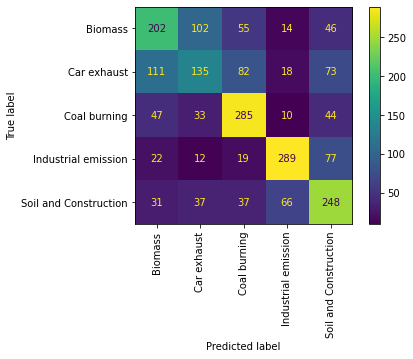

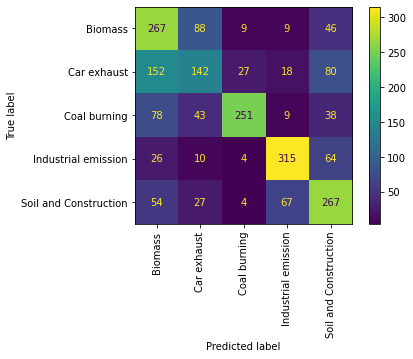

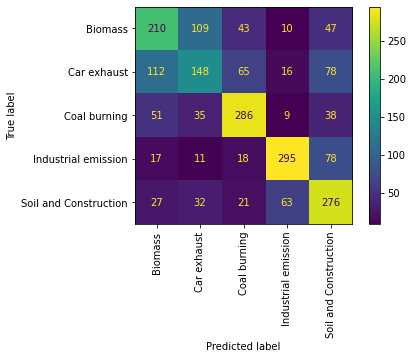

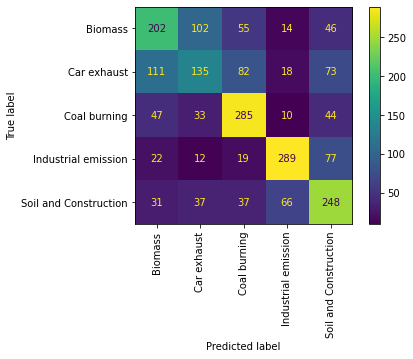

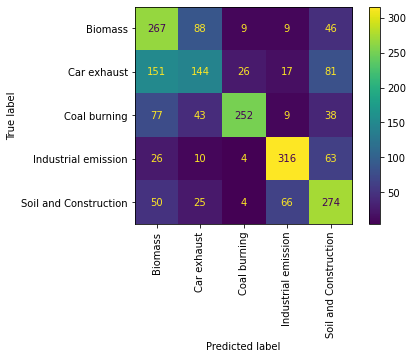

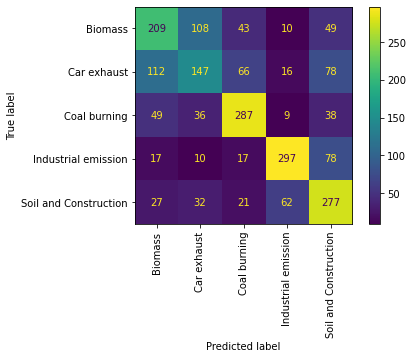

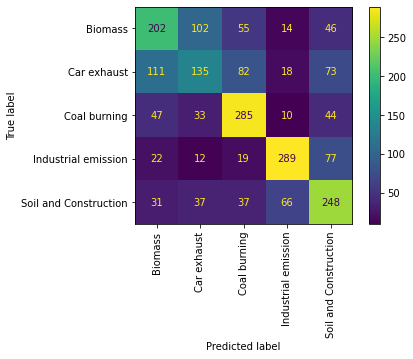

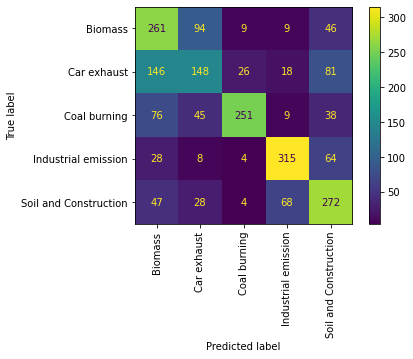

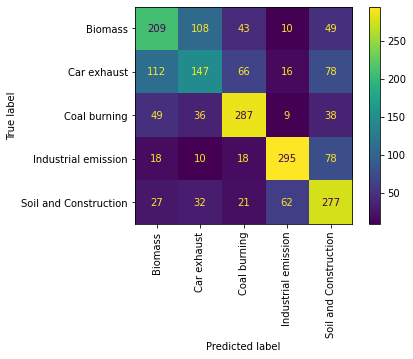

In [18]:
Test_dfresults = pd.DataFrame()
Train_dfresults = pd.DataFrame()
columns = ['KNN', 'GBC', 'Merged']
for i in range(3):
    clf1 = clf1.fit(Train_codes, TrainLabels)
    clf2 = clf2.fit(Train_codes, TrainLabels)
    eclf = eclf.fit(Train_codes, TrainLabels)

    plot_confusion_matrix(clf1, Test_codes, TestLabels, xticks_rotation='vertical')
    plt.savefig('Figures/ConfusionMatrixKNN' + str(i) + '.png', dpi = 300)
    plot_confusion_matrix(clf2, Test_codes, TestLabels, xticks_rotation='vertical')
    plt.savefig('Figures/ConfusionMatrixGBT' + str(i) + '.png', dpi = 300)
    plot_confusion_matrix(eclf, Test_codes, TestLabels, xticks_rotation='vertical')
    plt.savefig('Figures/ConfusionMatrixCombined' + str(i) + '.png', dpi = 300)

    testlist = [clf1.score(Test_codes, TestLabels), clf2.score(Test_codes, TestLabels), eclf.score(Test_codes, TestLabels)]
    trainlist = [clf1.score(Train_codes, TrainLabels), clf2.score(Train_codes, TrainLabels), eclf.score(Train_codes, TrainLabels)]

    Test_dfresults = pd.concat([Test_dfresults, pd.DataFrame(testlist)], axis = 1)
    Train_dfresults = pd.concat([Train_dfresults, pd.DataFrame(trainlist)], axis = 1)
    

In [33]:
Test_dfresults = Test_dfresults.T
Test_dfresults.columns = columns

Train_dfresults = Train_dfresults.T
Train_dfresults.columns = columns 


writer = ExcelWriter('outputdata/combinedmodelresults.xlsx', engine = 'xlsxwriter')
for i,j in enumerate([Test_dfresults, Train_dfresults]):
    j.to_excel(writer, sheet_name = ['Test', 'Train'][i])
writer.save()

In [35]:
Sourcetesting['KNN Predict'] = clf1.predict(Test_codes)
Sourcetesting['GBT Predict'] = clf2.predict(Test_codes)
Sourcetesting['Merged Predict'] = eclf.predict(Test_codes)

## Get the fingerprint for misclassification

In [22]:
#returns aggregate particles of a dataset
def aggregate_particles(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False)
    return finaldf

In [37]:
colsindex = ['KNN Predict', 'GBT Predict', 'Merged Predict']

for j in colsindex:
    misclassification = []
    for i in Sourcekeys:
        df = Sourcetesting[Sourcetesting['labels'] == i]
        df1 = df[df[j] != i]
        misclassification.append(aggregate_particles(df1[ELEMENTS]))

    writer = ExcelWriter('outputdata/misclassification' + j + '.xlsx', engine = 'xlsxwriter')
    for i,j in enumerate(misclassification):
        j.to_excel(writer, sheet_name = Sourcekeys[i])
    writer.save()


<ipython-input-22-6824c2d3354e>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total = np.array(total)
